___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 7<br><br>Image Classification with CNN<br><br>Malaria Data<br><h1>


# Dataset Info

The dataset contains 2 folders - 'parasitized', 'uninfected'

And a total of 27,558 images.

This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

# Import Libraries and Export Images from Zip_File

In [116]:
try:
    import jupyter_black
    jupyter_black.load()
except ImportError:
    print("You can safely ignore this message.")

You can safely ignore this message.


In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow import keras

# import warnings
# warnings.filterwarnings("ignore")
# warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option("display.max_columns", None)

In [3]:
import tensorflow as tf

if tf.config.list_physical_devices("GPU"):
    print("GPU support is enabled for this session.")
else:
    print("CPU will be used for this session.")

CPU will be used for this session.


In [4]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
SEED = 42
keras.utils.set_random_seed(SEED)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import zipfile

# Unzip the file
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/cell_images.zip", "r")
zip_ref = zipfile.ZipFile('./cell_images.zip')
zip_ref.extractall()
zip_ref.close()

# Recognizing and Understanding Data

In [7]:
my_data_dir = "cell_images"

In [8]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir)

['test', 'train']

In [9]:
test_path = os.path.join(my_data_dir, "test")
train_path = os.path.join(my_data_dir, "train")

In [10]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [11]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [12]:
classes = os.listdir(train_path)
classes

['parasitized', 'uninfected']

In [13]:
import pathlib

data_dir = pathlib.Path(train_path)  # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
# created a list of class_names from the subdirectories
print(class_names)

['parasitized' 'uninfected']


In [14]:
class_names

array(['parasitized', 'uninfected'], dtype='<U11')

**Let's check how many images there are.**

In [15]:
os.listdir(os.path.join(train_path, "parasitized"))[:5]

['C189P150ThinF_IMG_20151203_142224_cell_84.png',
 'C91P52ThinF_IMG_20150821_123116_cell_189.png',
 'C84P45ThinF_IMG_20150818_101226_cell_98.png',
 'C144P105ThinF_IMG_20151015_163432_cell_310.png',
 'C136P97ThinF_IMG_20151005_141803_cell_131.png']

In [16]:
len(os.listdir(os.path.join(train_path, "parasitized"))), len(
    os.listdir(os.path.join(train_path, "uninfected"))
)

(12479, 12479)

In [17]:
len(os.listdir(os.path.join(test_path, "parasitized"))), len(
    os.listdir(os.path.join(test_path, "uninfected"))
)

(1300, 1300)

In [18]:
# Walk through cell_images directory and list number of files
for dirpath, dirnames, filenames in os.walk(my_data_dir):
    print(
        f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
    )

There are 2 directories and 0 images in 'cell_images'.
There are 2 directories and 0 images in 'cell_images/test'.
There are 0 directories and 1300 images in 'cell_images/test/parasitized'.
There are 0 directories and 1300 images in 'cell_images/test/uninfected'.
There are 2 directories and 0 images in 'cell_images/train'.
There are 0 directories and 12479 images in 'cell_images/train/parasitized'.
There are 0 directories and 12479 images in 'cell_images/train/uninfected'.


**Let's take an example images from both train-parasitized and train-uninfected folders to observe process**

In [19]:
os.listdir(os.path.join(train_path, "parasitized"))[:10]

['C189P150ThinF_IMG_20151203_142224_cell_84.png',
 'C91P52ThinF_IMG_20150821_123116_cell_189.png',
 'C84P45ThinF_IMG_20150818_101226_cell_98.png',
 'C144P105ThinF_IMG_20151015_163432_cell_310.png',
 'C136P97ThinF_IMG_20151005_141803_cell_131.png',
 'C60P21thinF_IMG_20150804_105034_cell_105.png',
 'C176P137NThinF_IMG_20151201_122708_cell_126.png',
 'C136P97ThinF_IMG_20151005_142437_cell_119.png',
 'C173P134NThinF_IMG_20151130_115733_cell_227.png',
 'C85P46ThinF_IMG_20150820_105154_cell_221.png']

In [20]:
os.listdir(os.path.join(train_path, "parasitized"))[5]

'C60P21thinF_IMG_20150804_105034_cell_105.png'

In [21]:
para_cell_path = os.path.join(
    train_path, "parasitized", os.listdir(os.path.join(train_path, "parasitized"))[5]
)

In [22]:
para_cell_path

'cell_images/train/parasitized/C60P21thinF_IMG_20150804_105034_cell_105.png'

In [23]:
imread(para_cell_path)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], shape=(148, 160, 3), dtype=float32)

In [24]:
para_cell = imread(para_cell_path)

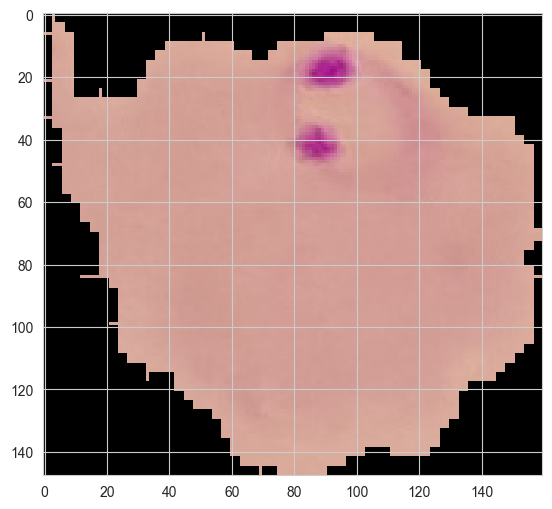

In [25]:
plt.imshow(para_cell);

In [26]:
para_cell.shape

(148, 160, 3)

In [27]:
os.listdir(os.path.join(train_path, "uninfected"))[:10]

['C13NThinF_IMG_20150614_131318_cell_179.png',
 'C205ThinF_IMG_20151106_152003_cell_21.png',
 'C230ThinF_IMG_20151112_150647_cell_1.png',
 'C134P95ThinF_IMG_20151005_121834_cell_65.png',
 'C141P102ThinF_IMG_20151005_214836_cell_132.png',
 'C182P143NThinF_IMG_20151201_171950_cell_93.png',
 'C181P142ThinF_IMG_20151127_160616_cell_54.png',
 'C142P103ThinF_IMG_20151005_223257_cell_18.png',
 'C80P41ThinF_IMG_20150817_110608_cell_62.png',
 'C144P105ThinF_IMG_20151015_163142_cell_66.png']

In [28]:
uninfected_cell_path = os.path.join(
    train_path, "uninfected/", os.listdir(os.path.join(train_path, "uninfected"))[5]
)

In [29]:
imread(uninfected_cell_path)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], shape=(67, 91, 3), dtype=float32)

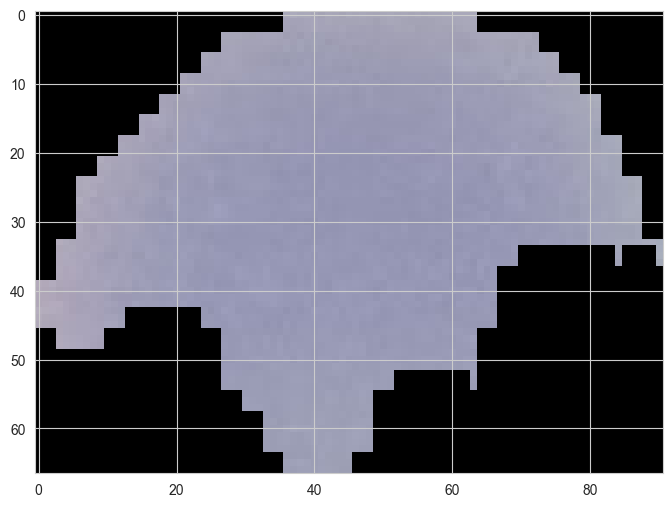

In [30]:
# plt.imshow(imread(uninfected_cell_path));
uninfected_cell = imread(uninfected_cell_path)
plt.imshow(uninfected_cell);

In [31]:
uninfected_cell.shape

(67, 91, 3)

In [32]:
# View a random image
import random


def view_random_image(target_dir, target_class):
    """Returns a randomly selected image after displaying it,
    given directory path and class names.
    Args:
        target_dir (str): Relative path to the target directory
        target_class (str): The name of the target class to randomly select a picture from
    Returns:
        img (np.ndarray): Randomly selected image as np.ndarray
    """
    # Setup target directory (we'll view images from here)
    target_folder = os.path.join(target_dir, target_class)

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = imread(os.path.join(target_folder, random_image[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")  # show the shape of the image

    return img

Image shape: (118, 127, 3)


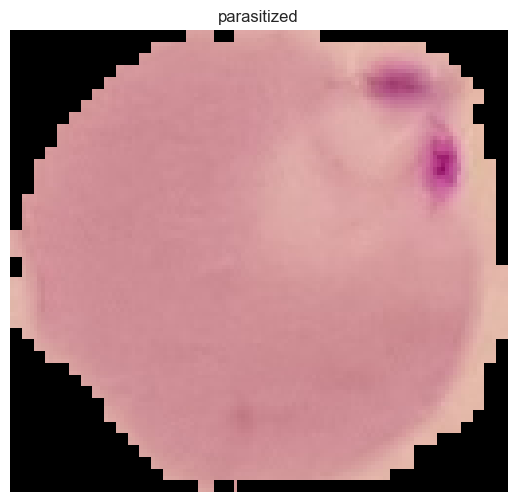

In [33]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path, target_class="parasitized")

Image shape: (145, 136, 3)


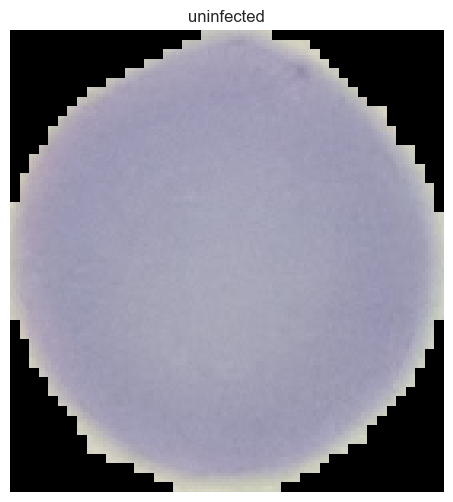

In [34]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path, target_class="uninfected")

Image shape: (115, 118, 3)


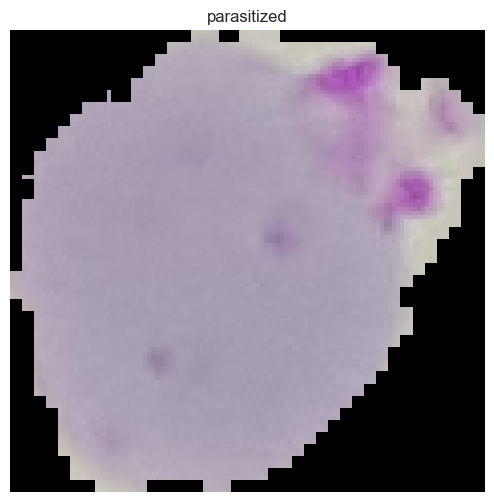

In [35]:
# View a random image from the training dataset
import random

img = view_random_image(
    target_dir=train_path, target_class=random.choice(class_names)
)  # get a random class name

# Data Preprocessing

## Defining Input Shape

**Let's decide on the final dimension of these images.**

In [36]:
uninfected_cell.shape

(67, 91, 3)

In [37]:
para_cell.shape

(148, 160, 3)

```python
x = []
y = []

for image in os.listdir(train_path+'uninfected'):
    img = imread(train_path+'uninfected/'+image)
    d1,d2,_ = img.shape
    x.append(d1)
    y.append(d2)
```

In [38]:
x = [
    imread(os.path.join(train_path, "uninfected", image)).shape[0]
    for image in os.listdir(os.path.join(train_path, "uninfected"))
    if "Thumbs.db" not in image
]
y = [
    imread(os.path.join(train_path, "uninfected", image)).shape[1]
    for image in os.listdir(os.path.join(train_path, "uninfected"))
    if "Thumbs.db" not in image
]

In [39]:
x[:5]

[127, 148, 115, 160, 145]

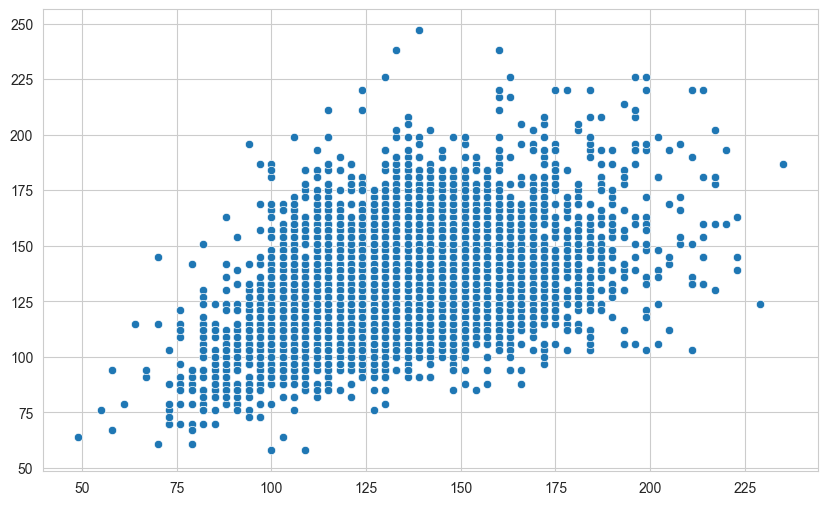

In [40]:
sns.scatterplot(x=x, y=y);

In [41]:
np.mean(x), np.median(x)

(np.float64(131.64820899110507), np.float64(130.0))

In [42]:
np.mean(y), np.median(y)

(np.float64(131.4041990544114), np.float64(130.0))

In [43]:
image_shape = (130, 130, 3)

## Scaling

**Let's check the images if they are needed to be scaled or not**

In [44]:
uninfected_cell.max()

np.float32(0.74509805)

In [45]:
para_cell.max()

np.float32(0.89411765)

As we see above, all images have already been scaled

## Image Data Generator

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [47]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.legacy.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  DEPRECATED.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_

In [48]:
image_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    # rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [49]:
val_image_gen = ImageDataGenerator()

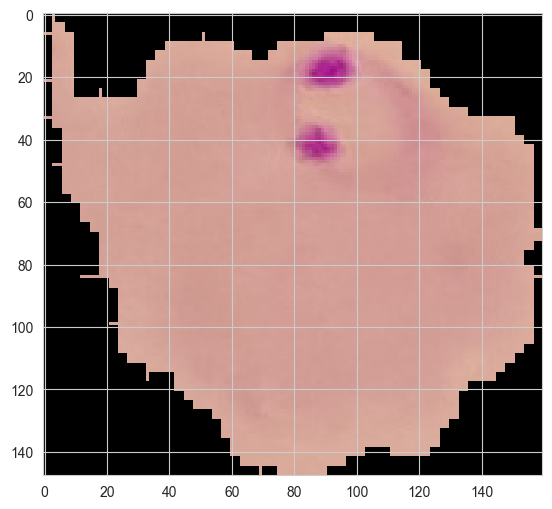

In [50]:
plt.imshow(para_cell);

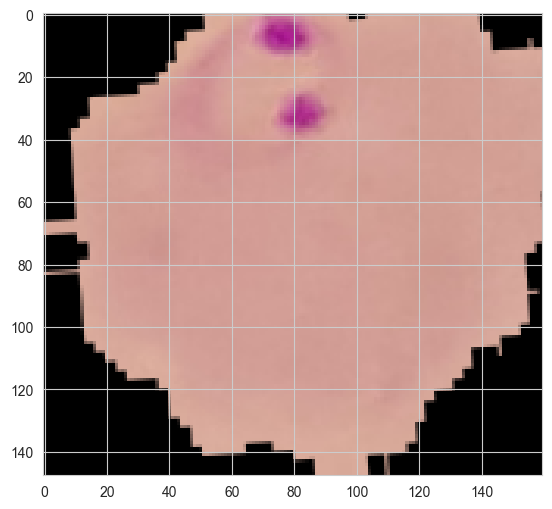

In [51]:
plt.imshow(image_gen.random_transform(para_cell));

### Taking the path to a directory & Generating batches of augmented data

flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

In [52]:
# help(image_gen.flow_from_directory)
# Takes the path to a directory & generates batches of augmented data.

In [53]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [54]:
val_image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [55]:
batch_size = 32

In [56]:
image_shape

(130, 130, 3)

In [57]:
train_image_gen = image_gen.flow_from_directory(
    directory=train_path,
    target_size=image_shape[:2],
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
)

Found 24958 images belonging to 2 classes.


In [58]:
test_image_gen = val_image_gen.flow_from_directory(
    directory=test_path,
    target_size=image_shape[:2],
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

Found 2600 images belonging to 2 classes.


In [59]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [60]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [61]:
train_image_gen

In [62]:
train_image_gen[0][0].shape

(32, 130, 130, 3)

In [63]:
train_image_gen[0][0][0].shape

(130, 130, 3)

In [64]:
len(train_image_gen), len(test_image_gen)

(780, 82)

In [65]:
len(train_image_gen) * batch_size, len(test_image_gen) * batch_size

(24960, 2624)

In [66]:
# Get a sample of the training data batch
images, labels = next(train_image_gen)  # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [67]:
# Get a sample of the testing data batch
images, labels = next(test_image_gen)  # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

# Modelling-1

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    Dropout,
    Flatten,
    Dense,
    Conv2D,
    MaxPooling2D,
)
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
model1 = Sequential()

model1.add(
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation="relu")
)
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))

############################

model1.add(Flatten())

############################

model1.add(Dense(128))
model1.add(Activation("relu"))

###########################

model1.add(Dropout(0.5))

###########################

model1.add(Dense(1))
model1.add(Activation("sigmoid"))

############################

# optimizer = keras.optimizers.Adam(lr=0.01)
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,209 (6.34 MB)

 Trainable params: 1,662,209 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [72]:
model1.fit(
    train_image_gen,
    epochs=10,
    steps_per_epoch=len(train_image_gen),
    validation_data=test_image_gen,
    validation_steps=len(test_image_gen),
    callbacks=[early_stop],
)

Epoch 1/10


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


780/780 ━━━━━━━━━━━━━━━━━━━━ 124s 158ms/step - accuracy: 0.5469 - loss: 3.4964 - val_accuracy: 0.5865 - val_loss: 0.6741
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 125s 161ms/step - accuracy: 0.5884 - loss: 0.6730 - val_accuracy: 0.5696 - val_loss: 0.6881
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 129s 166ms/step - accuracy: 0.5997 - loss: 0.6659 - val_accuracy: 0.6323 - val_loss: 0.6513
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 135s 173ms/step - accuracy: 0.6087 - loss: 0.6613 - val_accuracy: 0.6281 - val_loss: 0.6623
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - accuracy: 0.6344 - loss: 0.6404 - val_accuracy: 0.9273 - val_loss: 0.2156
Epoch 6/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 125s 160ms/step - accuracy: 0.9219 - loss: 0.2480 - val_accuracy: 0.9431 - val_loss: 0.1885
Epoch 7/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 1057s 1s/step - accuracy: 0.9414 - loss: 0.1929 - val_accuracy: 0.9546 - val_loss: 0.1448
Epoch 8/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 115s 148ms/step - accuracy: 0.9439 - loss: 0.1804

In [73]:
model1.metrics_names

['loss', 'compile_metrics']

In [74]:
summary = pd.DataFrame(model1.history.history)
summary.head()

,accuracy,loss,val_accuracy,val_loss
0,0.567,1.155,0.587,0.674
1,0.593,0.672,0.570,0.688
2,0.605,0.664,0.632,0.651
3,0.612,0.660,0.628,0.662
4,0.707,0.557,0.927,0.216


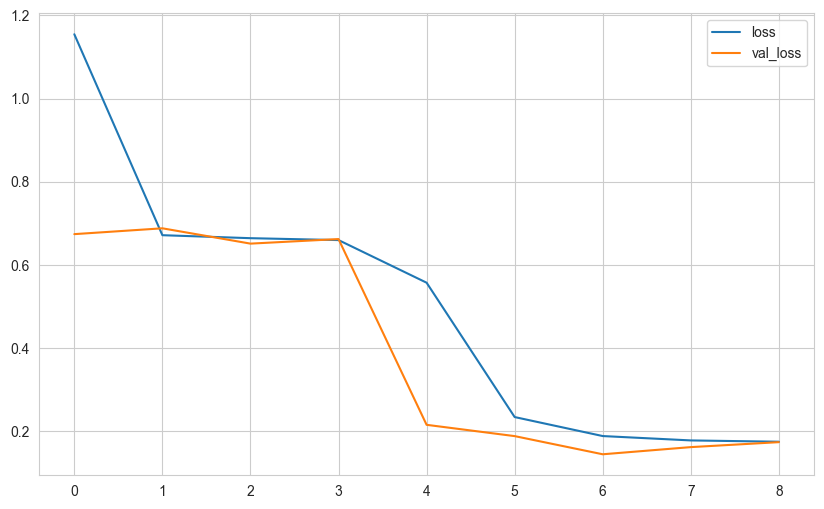

In [75]:
summary[["loss", "val_loss"]].plot();

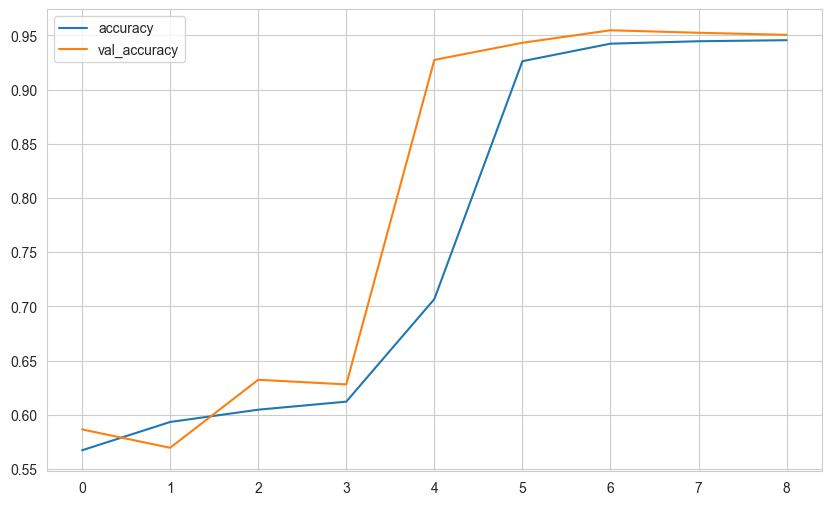

In [76]:
summary[["accuracy", "val_accuracy"]].plot();

# Evaluation on Test Data

In [77]:
from sklearn.metrics import classification_report, confusion_matrix

In [78]:
score = model1.evaluate(test_image_gen)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9461 - loss: 0.1518
Test loss: 0.14481046795845032
Test accuracy: 0.9546154141426086


In [79]:
pred_prob = model1.predict(test_image_gen)

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


In [80]:
pred_prob

array([[2.2887090e-05],
       [1.2269797e-03],
       [5.1943691e-05],
       ...,
       [9.9424189e-01],
       [9.9212694e-01],
       [9.8225611e-01]], shape=(2600, 1), dtype=float32)

In [81]:
y_pred = pred_prob > 0.5

In [82]:
y_pred

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]], shape=(2600, 1))

In [83]:
y_test = test_image_gen.classes
y_test

array([0, 0, 0, ..., 1, 1, 1], shape=(2600,), dtype=int32)

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.95      0.96      0.96      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [85]:
confusion_matrix(y_test, y_pred)

array([[1228,   72],
       [  46, 1254]])

# Modelling-2

In [86]:
model2 = Sequential()

model2.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        input_shape=image_shape,
        padding="same",
        activation="relu",
    )
)
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())


model2.add(Dense(128))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))

model2.add(Dense(1))
model2.add(Activation("sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 130, 130, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 65, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 65, 65, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,198,721 (8.39 MB)

 Trainable params: 2,198,721 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

In [89]:
model2.fit(
    train_image_gen,
    epochs=15,
    steps_per_epoch=len(train_image_gen),
    validation_data=test_image_gen,
    validation_steps=len(test_image_gen),
    callbacks=[early_stop],
)

Epoch 1/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 3010s 4s/step - accuracy: 0.5100 - loss: 1.0469 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 2382s 3s/step - accuracy: 0.5219 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 3/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - accuracy: 0.5216 - loss: 0.6929 - val_accuracy: 0.5650 - val_loss: 0.6925
Epoch 4/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 911s 1s/step - accuracy: 0.5237 - loss: 0.6916 - val_accuracy: 0.5623 - val_loss: 0.6920
Epoch 5/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 904s 1s/step - accuracy: 0.7794 - loss: 0.4547 - val_accuracy: 0.9350 - val_loss: 0.1873
Epoch 6/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 905s 1s/step - accuracy: 0.9443 - loss: 0.1809 - val_accuracy: 0.9442 - val_loss: 0.2028
Epoch 7/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 888s 1s/step - accuracy: 0.9503 - loss: 0.1661 - val_accuracy: 0.9481 - val_loss: 0.1844
Epoch 8/15
780/780 ━━━━━━━━━━━━━━━━━━━━ 902s 1s/step - accuracy: 0.9507 - loss: 0.1674 - val_ac

In [90]:
model2.metrics_names

['loss', 'compile_metrics']

In [91]:
summary = pd.DataFrame(model2.history.history)
summary.head()

,accuracy,loss,val_accuracy,val_loss
0,0.510,0.752,0.500,0.693
1,0.521,0.696,0.500,0.692
2,0.520,0.693,0.565,0.693
3,0.538,0.690,0.562,0.692
4,0.879,0.313,0.935,0.187


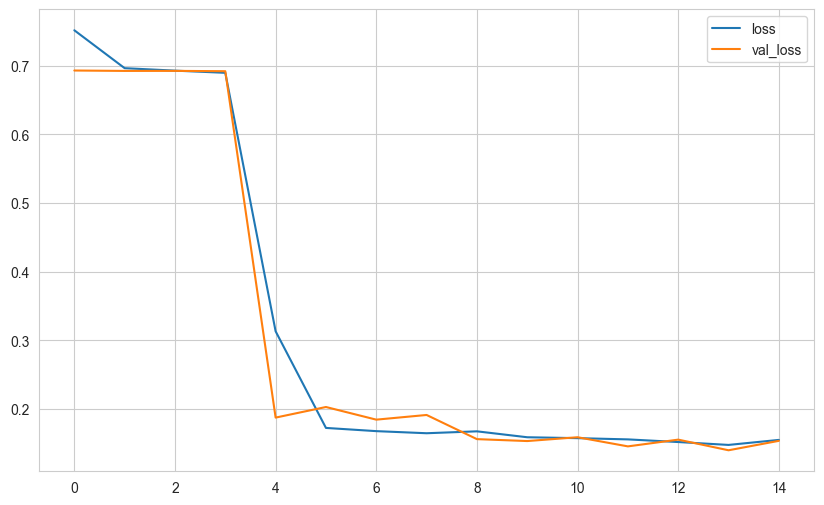

In [92]:
summary[["loss", "val_loss"]].plot()
plt.show()

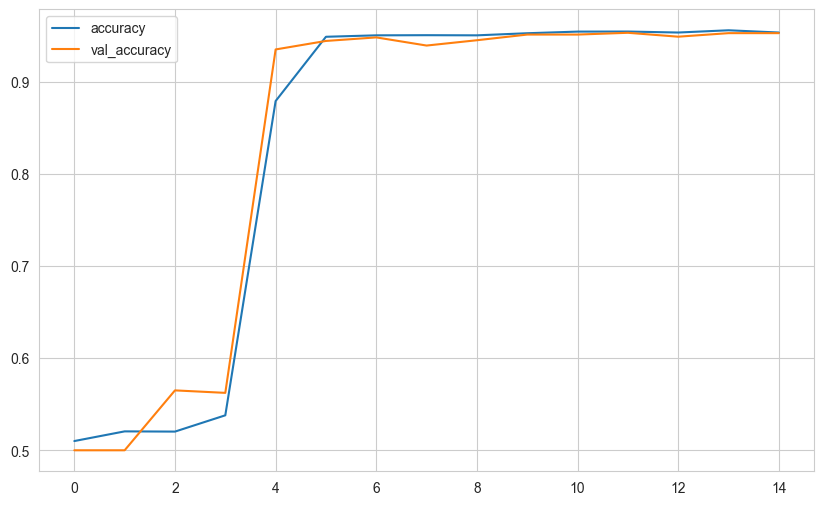

In [93]:
summary[["accuracy", "val_accuracy"]].plot()
plt.show()

# Evaluation on Test Data

In [94]:
score = model2.evaluate(test_image_gen)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.9491 - loss: 0.1286
Test loss: 0.13973428308963776
Test accuracy: 0.9526923298835754


In [95]:
pred_prob = model2.predict(test_image_gen)

82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 329ms/step


In [96]:
y_pred = pred_prob > 0.5

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [98]:
confusion_matrix(y_test, y_pred)

array([[1236,   64],
       [  59, 1241]])

In [117]:
model1.save("malaria_model.keras")

# Prediction

In [118]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [119]:
model = load_model("malaria_model.keras")

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [120]:
target_class = random.choice(class_names)
target_class

np.str_('parasitized')

In [121]:
random_image = random.sample(os.listdir(os.path.join(test_path, target_class)), 1)
random_image

['C59P20thinF_IMG_20150803_113139_cell_58.png']

In [122]:
image_path = os.path.join(test_path, target_class, random_image[0])
image_path

'cell_images/test/parasitized/C59P20thinF_IMG_20150803_113139_cell_58.png'

In [123]:
my_image = image.load_img(image_path, target_size=image_shape)

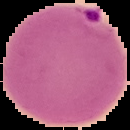

In [124]:
my_image

In [125]:
type(my_image)

PIL.PngImagePlugin.PngImageFile

In [126]:
# my_image = np.array(my_image)
my_image = image.img_to_array(my_image)

In [127]:
my_image.shape

(130, 130, 3)

In [128]:
my_image = np.expand_dims(my_image, axis=0)

In [129]:
my_image.shape

(1, 130, 130, 3)

In [130]:
model.predict(my_image)

2025-02-27 16:02:56.753852: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-27 16:02:56.754178: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[0.01562165]], dtype=float32)

In [131]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [132]:
def pred_and_plot(model, img_size):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    target_class = random.choice(class_names)
    random_image = random.sample(os.listdir(os.path.join(test_path, target_class)), 1)
    img_path = os.path.join(test_path, target_class, random_image[0])
    img = image.load_img(img_path, target_size=img_size)
    img = np.array(img)

    # Make a prediction
    pred = model.predict(np.expand_dims(img, axis=0))
    print("prediction_probability: ", pred.max())

    # Get the predicted class
    if len(pred[0]) > 1:  # check for multi-class
        pred_class = class_names[pred.argmax()]  # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])]  # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
prediction_probability:  0.00849468


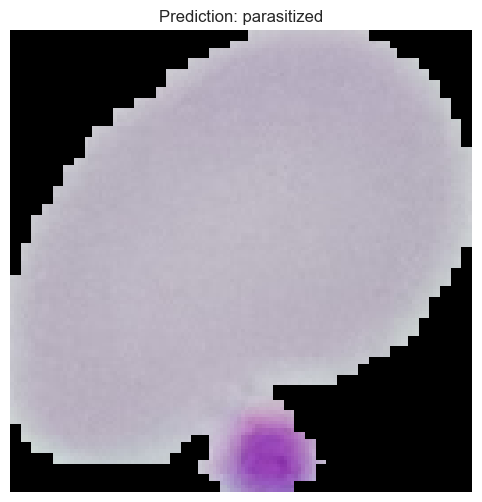

In [133]:
pred_and_plot(model, (130, 130))

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___